<a href="https://colab.research.google.com/github/Doppler-67/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
#!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
#!cp mystem /root/.local/bin/mystem

In [79]:
#!pip install transformers

In [80]:
import numpy as np
import pandas as pd
import torch
import nltk
import re
import transformers
from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from pymystem3 import Mystem 

In [81]:
col_names = ['id', 'tdate', 'tmane', 'text', 'toxic', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

In [82]:
pos_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/positive.csv', sep=';', header=None, names=col_names)
neg_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/negative.csv', sep=';', header=None, names=col_names)

In [83]:
pos_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [84]:
neg_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [85]:
neg_data['toxic'] = 0

Соединим все один датасет.

In [86]:
data = pd.concat([pos_data, neg_data])

In [87]:
data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Отбросим ненужные колонки.

In [88]:
data = data[['text', 'toxic']]

In [89]:
data['toxic'] = data['toxic'].astype(bool)

In [90]:
data.head()

,text,toxic
0,"@first_timee хоть я и школота, но поверь, у на...",True
1,"Да, все-таки он немного похож на него. Но мой ...",True
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,True
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",True
4,@irina_dyshkant Вот что значит страшилка :D\nН...,True


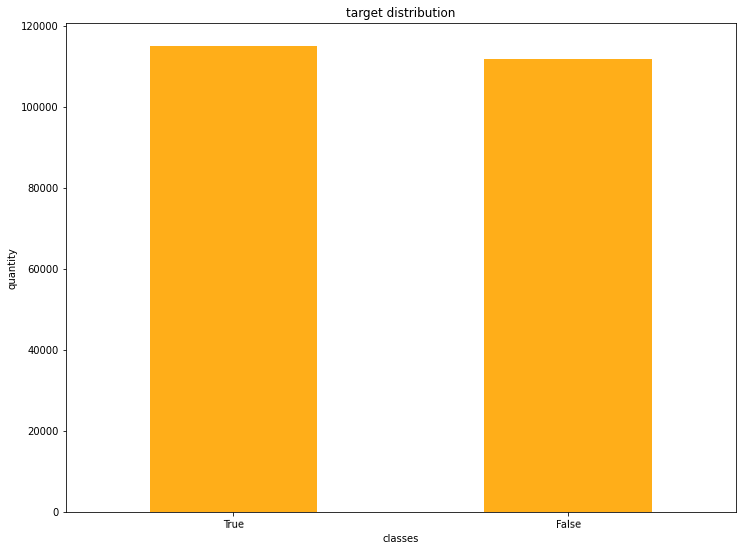

In [91]:
data['toxic'].value_counts().plot(kind='bar', title='target distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

Теперь очистим текст от лишних символов.

In [92]:
def clear_text(text):
    t = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    t = ' '.join(t.split())
    return t

In [93]:
data['clear_text'] = data['text'].apply(clear_text)

In [94]:
data = data.sample(frac=1).reset_index(drop=True)

In [95]:
data.head()

,text,toxic,clear_text
0,"Долбаный Т9....Сегодня вместо ""доброе утро кот...",False,Долбаный Т Сегодня вместо доброе утро котя нап...
1,@ArtemidaReMinor Хи сегодня ад на автозаводе б...,False,Хи сегодня ад на автозаводе был прям жопа полная
2,"Хумус, кускус, хацилим и шкедей марак )) Мален...",True,Хумус кускус хацилим и шкедей марак Маленькие ...
3,@bolvs походу только тебе( я никому не нужен(,False,походу только тебе я никому не нужен
4,"так обидно было,такое наплевательское отношени...",False,так обидно было такое наплевательское отношени...


In [96]:
data = data.head(2300) # !!!

# **TF-IDF**

In [97]:
m = Mystem()

In [98]:
def lemmatize_text(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

In [99]:
data['lemm_text'] = data['clear_text'].apply(lemmatize_text)

In [100]:
data.head()

,text,toxic,clear_text,lemm_text
0,"Долбаный Т9....Сегодня вместо ""доброе утро кот...",False,Долбаный Т Сегодня вместо доброе утро котя нап...,долбаный т сегодня вместо добрый утр...
1,@ArtemidaReMinor Хи сегодня ад на автозаводе б...,False,Хи сегодня ад на автозаводе был прям жопа полная,хи сегодня ад на автозавод быть пр...
2,"Хумус, кускус, хацилим и шкедей марак )) Мален...",True,Хумус кускус хацилим и шкедей марак Маленькие ...,хумус кускус хацилим и шкедой марака...
3,@bolvs походу только тебе( я никому не нужен(,False,походу только тебе я никому не нужен,поход только ты я никто не нужный
4,"так обидно было,такое наплевательское отношени...",False,так обидно было такое наплевательское отношени...,так обидно быть такой наплевательский ...


In [101]:
nltk.download('stopwords')
stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
x_train, x_test, y_train, y_test = train_test_split(data['lemm_text'], data['toxic'], train_size=0.8, random_state=67)

In [103]:
train_corpus = x_train.values.astype('U')
test_corpus = x_test.values.astype('U')

In [104]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [105]:
train_tf_idf = count_tf_idf.fit_transform(x_train)
test_tf_idf = count_tf_idf.transform(x_test)

In [106]:
train_tf_idf.shape, test_tf_idf.shape

((1840, 4735), (460, 4735))

In [107]:
model = LogisticRegression(max_iter=1000, random_state=67)

In [108]:
model.fit(train_tf_idf, y_train)
prediction = model.predict(test_tf_idf)

In [109]:
f1_score(y_test, prediction)

0.6586345381526104

# **ruBERT**

In [ ]:
tokenizer = transformers.BertTokenizer('/content/drive/MyDrive/sentiment_analysis/vocab.txt')

In [ ]:
tokenized = data['clear_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [ ]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
config = transformers.BertConfig.from_json_file(
    '/content/drive/MyDrive/sentiment_analysis/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/content/drive/MyDrive/sentiment_analysis/rubert_model.bin', config=config)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [ ]:
features = np.concatenate(embeddings)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, data['toxic'], train_size=0.8, random_state=67)

In [ ]:
model = LogisticRegression(random_state=67, max_iter=10000)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('f1: ', f1_score(predictions, y_test))